In [1]:
import rospy
from sensor_msgs.msg import Image
from cv_bridge import CvBridge
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
from std_msgs.msg import Float64
from dynamixel_sdk import *
import datetime
import threading
import serial
import re
import pandas as pd
import glob


In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>div.output_scroll { height: 44em; }</style>"))

/tmp/ipykernel_19577/2284580335.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [3]:
%%javascript

window.scroll_flag = true
window.scroll_exit = false
window.scroll_delay = 100

$(".output_scroll").each(function() {
    $(this)[0].scrollTop = $(this)[0].scrollHeight;
});

function callScrollToBottom() {
    setTimeout(scrollToBottom, window.scroll_delay);
}

function scrollToBottom() {
    if (window.scroll_exit) {
        return;
    }
    if (!window.scroll_flag) {
        callScrollToBottom();
        return;
    };
    
    $(".output_scroll").each(function() {
        if (!$(this).attr('scroll_checkbox')){
            window.scroll_flag = true;
            $(this).attr('scroll_checkbox',true);
            var div = document.createElement('div');
            var checkbox = document.createElement('input');
            checkbox.type = "checkbox";
            checkbox.onclick = function(){window.scroll_flag = checkbox.checked}
            checkbox.checked = "checked"
            div.append("Auto-Scroll-To-Bottom: ");
            div.append(checkbox);
            $(this).parent().before(div);
        }
        
        $(this)[0].scrollTop = $(this)[0].scrollHeight;
    });
    callScrollToBottom();
}
scrollToBottom();

<IPython.core.display.Javascript object>

In [4]:
class Dynamixel_motor:
    def __init__(self, dxl_id, baudrate, device_name):
        self.dxl_id = dxl_id
        self.baudrate = baudrate
        self.device_name = device_name
        self.protocol_version = 2.0

        # Initialize PortHandler instance
        # Set the port path
        # Get methods and members of PortHandlerLinux or PortHandlerWindows
        self.portHandler = PortHandler(self.device_name)

        # Initialize PacketHandler instance
        # Set the protocol version
        # Get methods and members of Protocol1PacketHandler or Protocol2PacketHandler
        self.packetHandler = PacketHandler(self.protocol_version)

        # Open port
        if self.portHandler.openPort():
            print("Succeeded to open the port")
        else:
            print("Failed to open the port")
            print("Press any key to terminate...")
            self.close_port()

        # Set port baudrate
        if self.portHandler.setBaudRate(self.baudrate):
            print("Succeeded to change the baudrate")
        else:
            print("Failed to change the baudrate")
            print("Press any key to terminate...")
            self.close_port()

    def __del__(self):
        print('Destructor called.')
        self.portHandler.closePort()

    def close_port(self):
        self.torque_disable()
        self.portHandler.closePort()
        print('closing port.')

    def ping_motor(self):

        # Try to ping the Dynamixel
        # Get Dynamixel model number
        dxl_model_number, dxl_comm_result, dxl_error = self.packetHandler.ping(self.portHandler, self.dxl_id)
        print(f"dxl_model_number is: {dxl_model_number}")
        print(f"dxl_comm_result is: {dxl_comm_result}")
        print(f"dxl_error is: {dxl_error}")
        print(f"COMM_SUCCESS is {COMM_SUCCESS}")
        if dxl_comm_result != COMM_SUCCESS:
            print("statement 0")
            print("%s" % self.packetHandler.getTxRxResult(dxl_comm_result))
            self.close_port()
        elif dxl_error != 0:
            print("statement 1")
            print("%s" % self.packetHandler.getRxPacketError(dxl_error))
            self.close_port()
        else:
            print("statement 2")
            print("[ID:%03d] ping Succeeded. Dynamixel model number : %d" % (self.dxl_id, dxl_model_number))

    def torque_enable(self):
        TORQUE_ENABLE_REG = 64
        TORQUE_ENABLE = 1
        result, error = self.packetHandler.write4ByteTxRx(self.portHandler, self.dxl_id, TORQUE_ENABLE_REG, TORQUE_ENABLE)
        return

    def torque_disable(self):
        TORQUE_ENABLE_REG = 64
        TORQUE_ENABLE = 0
        result, error = self.packetHandler.write4ByteTxRx(self.portHandler, self.dxl_id, TORQUE_ENABLE_REG, TORQUE_ENABLE)
        return

    def read_operation_mode(self):
        OPERATING_MODE_REG = 11
        data, result, error = self.packetHandler.read1ByteTxRx(self.portHandler, self.dxl_id, OPERATING_MODE_REG)
        print(f"data is: {data}")
        print(f"result is: {result}")
        print(f"error is: {error}")
        return data

    def set_current_position_mode(self):
        OPERATING_MODE_REG = 11
        OPERATION_MODE = 5
        result, error = self.packetHandler.write1ByteTxRx(self.portHandler, self.dxl_id, OPERATING_MODE_REG, OPERATION_MODE)
        return

    def set_goal_current(self, GOAL_CURRENT):
        GOAL_CURRENT_REG = 102
        result, error = self.packetHandler.write2ByteTxRx(self.portHandler, self.dxl_id, GOAL_CURRENT_REG, GOAL_CURRENT)
        return

    def read_present_position(self):
        PRESENT_POSITION_REG = 132
        PRESENT_POSITION, result, error = self.packetHandler.read4ByteTxRx(self.portHandler, self.dxl_id, PRESENT_POSITION_REG)
        return PRESENT_POSITION

    def set_goal_position(self, GOAL_POSITION):
        GOAL_POSITION_REG = 116
        result, error = self.packetHandler.write4ByteTxRx(self.portHandler, self.dxl_id, GOAL_POSITION_REG, GOAL_POSITION)
        return

    def read_present_current(self):
        PRESENT_CURRENT_REG = 126
        PRESENT_CURRENT, result, error = self.packetHandler.read2ByteTxRx(self.portHandler, self.dxl_id, PRESENT_CURRENT_REG)
        return PRESENT_CURRENT


Succeeded to open the port
Succeeded to change the baudrate
data is: 5
result is: 0
error is: 0
[INFO] [1677363749.477173]: Timing images
Enter something: 
b'000.0,000.0,000-0.1,000-0.0\r\n'
[INFO] [1677363763.502548]: Image received...


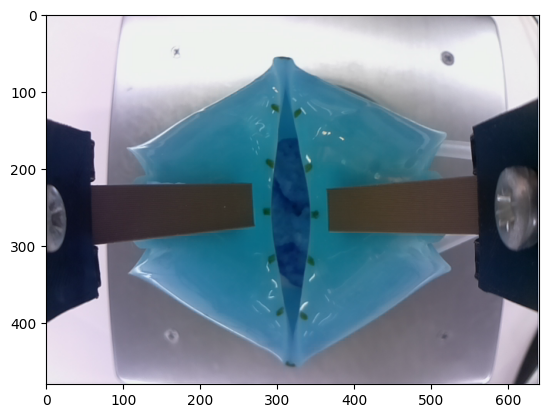

b'066.6,057.1,0250.6,0252.2\r\n'
Data number 1
['066.6', '057.1', '0250.6', '0252.2']
b'068.4,063.0,0333.8,0169.0\r\n'
['068.4', '063.0', '0333.8', '0169.0']
Enter something: 
b'000.0,000.0,0001.1,0001.3\r\n'
[INFO] [1677363776.718777]: Image received...


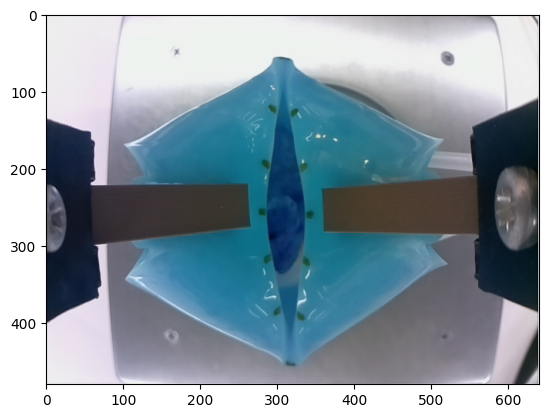

b'062.0,066.0,0268.7,0269.3\r\n'
Data number 2
['062.0', '066.0', '0268.7', '0269.3']
b'057.8,062.6,0346.5,0181.4\r\n'
['057.8', '062.6', '0346.5', '0181.4']
Enter something: 
b'000.0,000.0,0004.1,0004.1\r\n'
[INFO] [1677363788.497463]: Image received...


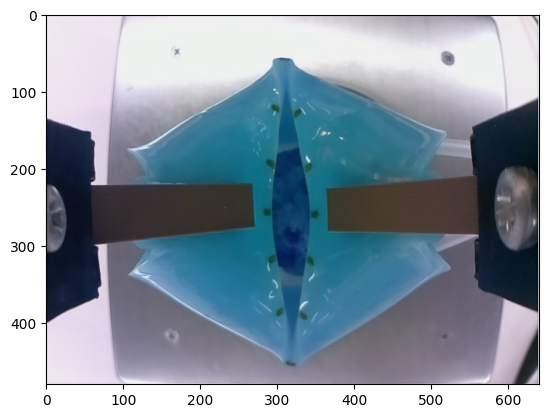

b'034.9,050.4,0289.2,0290.0\r\n'
Data number 3
['034.9', '050.4', '0289.2', '0290.0']
b'033.2,049.5,0378.4,0213.3\r\n'
['033.2', '049.5', '0378.4', '0213.3']
Enter something: 
b'000.0,000.0,0001.5,0001.5\r\n'
[INFO] [1677363801.489770]: Image received...


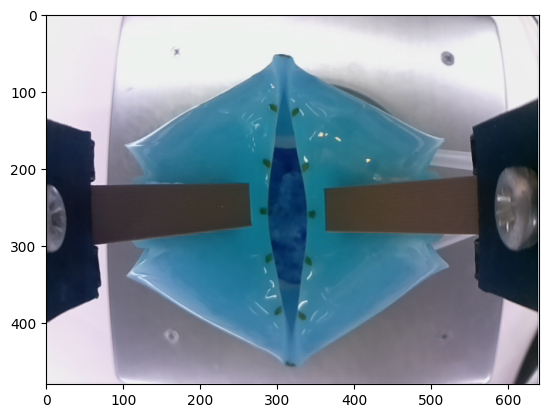

b'058.4,039.7,0290.4,0291.2\r\n'
Data number 4
['058.4', '039.7', '0290.4', '0291.2']
b'060.3,042.3,0373.5,0208.0\r\n'
['060.3', '042.3', '0373.5', '0208.0']
Enter something: 
b'000.0,000.0,0001.5,0001.5\r\n'
[INFO] [1677363814.490082]: Image received...


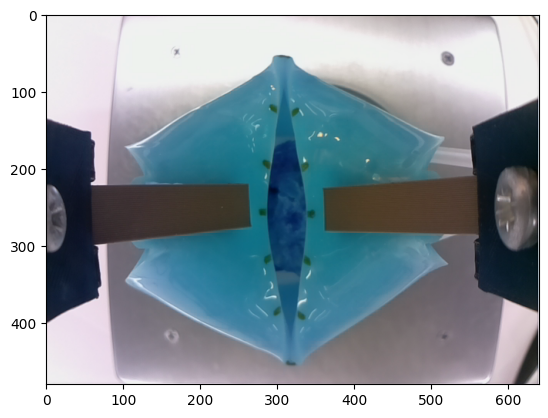

b'038.5,057.2,0283.6,0283.0\r\n'
Data number 5
['038.5', '057.2', '0283.6', '0283.0']
b'036.2,057.8,0365.3,0199.6\r\n'
['036.2', '057.8', '0365.3', '0199.6']
Enter something: 
b'000.0,000.0,0004.1,0003.7\r\n'
[INFO] [1677363826.203532]: Image received...


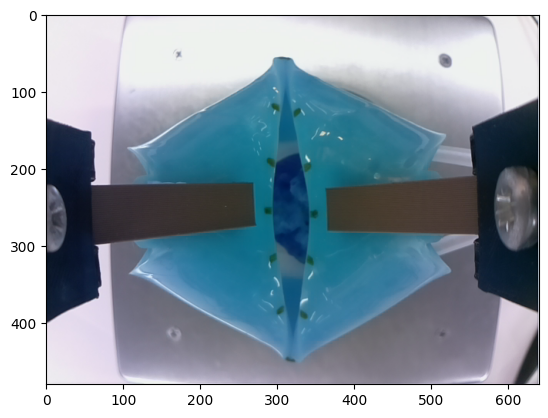

b'058.6,053.2,0280.7,0280.6\r\n'
Data number 6
['058.6', '053.2', '0280.7', '0280.6']
b'057.7,054.2,0372.7,0206.2\r\n'
['057.7', '054.2', '0372.7', '0206.2']
Enter something: 
b'000.0,000.0,0000.2,0000.2\r\n'
[INFO] [1677363848.967610]: Image received...


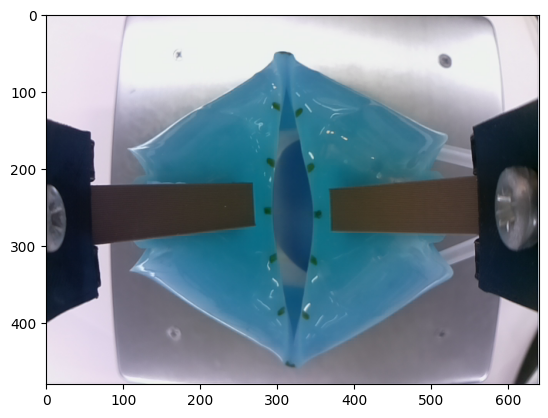

b'068.4,042.4,0288.1,0289.2\r\n'
Data number 7
['068.4', '042.4', '0288.1', '0289.2']
b'070.4,042.7,0390.7,0205.4\r\n'
['070.4', '042.7', '0390.7', '0205.4']
Enter something: 
b'000.0,000.0,0003.7,0004.0\r\n'
[INFO] [1677363860.735891]: Image received...


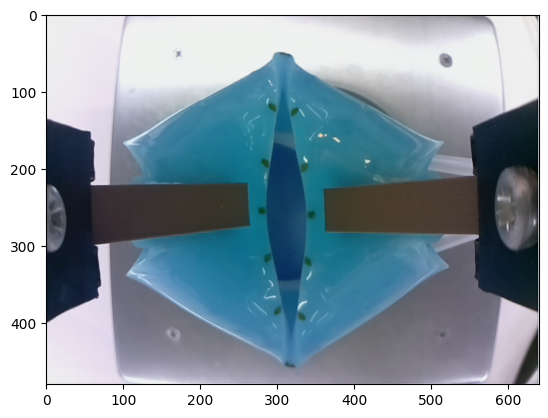

b'070.5,055.9,0316.9,0318.8\r\n'
Data number 8
['070.5', '055.9', '0316.9', '0318.8']
b'067.3,054.2,0411.5,0226.2\r\n'
['067.3', '054.2', '0411.5', '0226.2']
Enter something: 
b'000.0,000.0,0006.1,0003.5\r\n'
[INFO] [1677363872.702113]: Image received...


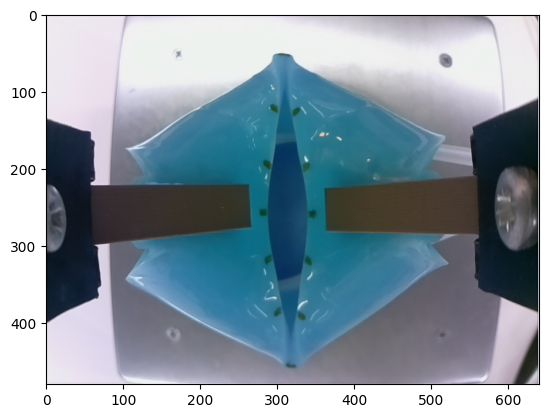

b'057.4,061.2,0316.9,0316.2\r\n'
Data number 9
['057.4', '061.2', '0316.9', '0316.2']
b'055.4,059.3,0414.7,0227.1\r\n'
['055.4', '059.3', '0414.7', '0227.1']
Enter something: 
b'000.0,000.0,0002.9,0003.5\r\n'
[INFO] [1677363884.982913]: Image received...


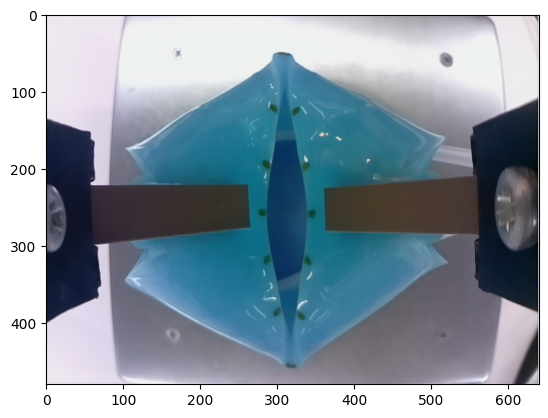

b'059.6,056.8,0313.3,0315.2\r\n'
Data number 10
['059.6', '056.8', '0313.3', '0315.2']
b'056.4,056.2,0408.3,0223.4\r\n'
['056.4', '056.2', '0408.3', '0223.4']
Enter something: 
b'000.0,000.0,0002.0,0002.2\r\n'
[INFO] [1677363897.488829]: Image received...


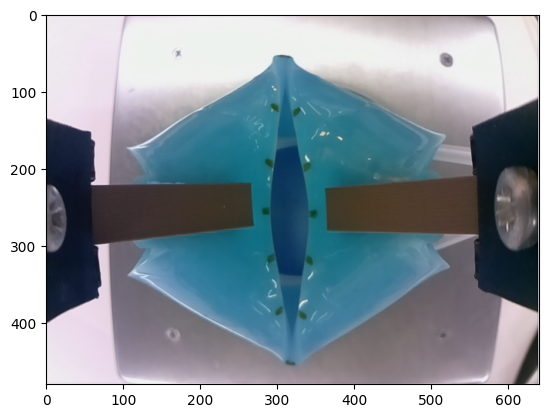

b'054.3,051.5,0288.8,0291.1\r\n'
Data number 11
['054.3', '051.5', '0288.8', '0291.1']
b'053.8,050.1,0392.2,0207.1\r\n'
['053.8', '050.1', '0392.2', '0207.1']
Enter something: 
b'000.0,000.0,0002.9,0003.0\r\n'
[INFO] [1677363909.493874]: Image received...


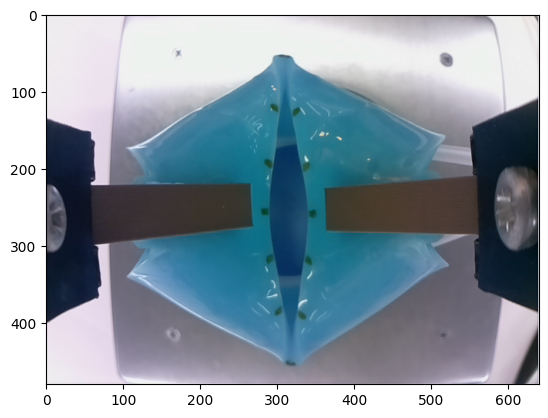

b'051.8,056.1,0297.9,0299.4\r\n'
Data number 12
['051.8', '056.1', '0297.9', '0299.4']
b'050.5,052.1,0398.6,0213.4\r\n'
['050.5', '052.1', '0398.6', '0213.4']
Enter something: 
b'000.0,000.0,0000.2,0000.2\r\n'
[INFO] [1677363930.987246]: Image received...


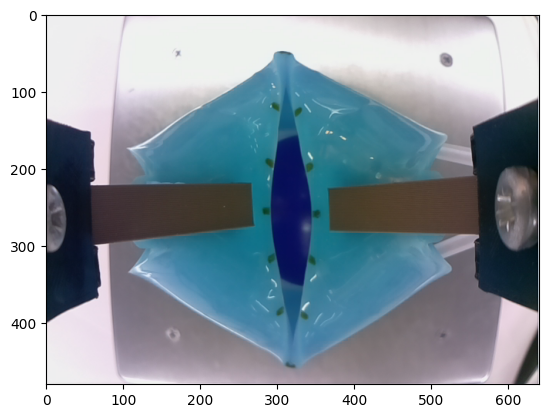

b'059.2,047.3,0295.0,0296.0\r\n'
Data number 13
['059.2', '047.3', '0295.0', '0296.0']
b'058.7,047.4,0399.4,0202.9\r\n'
['058.7', '047.4', '0399.4', '0202.9']
Enter something: 
b'000.0,000.0,0001.3,0001.3\r\n'
[INFO] [1677363944.237480]: Image received...


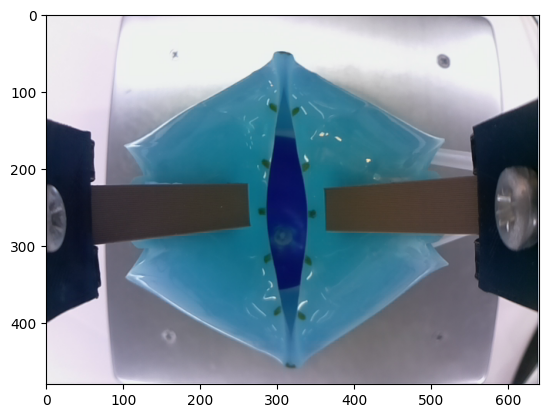

b'061.3,047.7,0309.8,0310.7\r\n'
Data number 14
['061.3', '047.7', '0309.8', '0310.7']
b'059.0,047.3,0409.0,0211.8\r\n'
['059.0', '047.3', '0409.0', '0211.8']
Enter something: 
b'000.0,000.0,0002.8,0002.7\r\n'
[INFO] [1677363956.235773]: Image received...


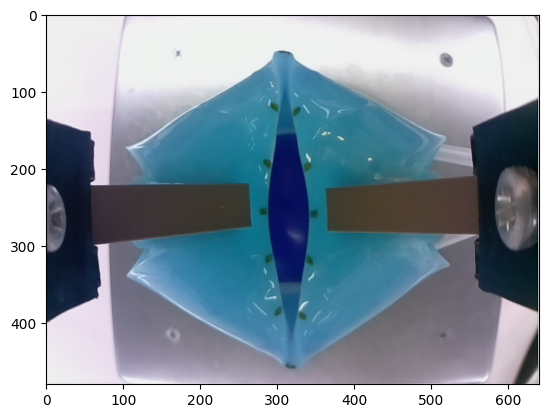

b'056.3,061.1,0329.5,0330.9\r\n'
Data number 15
['056.3', '061.1', '0329.5', '0330.9']
b'057.2,058.5,0433.9,0236.0\r\n'
['057.2', '058.5', '0433.9', '0236.0']
Enter something: 
b'000.0,000.0,0010.0,0006.9\r\n'
[INFO] [1677363967.968655]: Image received...


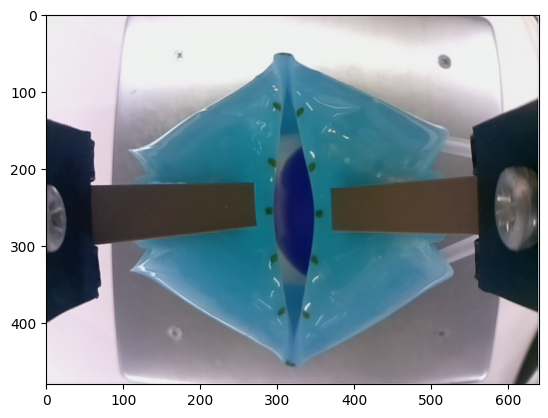

b'053.5,043.9,0336.4,0334.3\r\n'
Data number 16
['053.5', '043.9', '0336.4', '0334.3']
b'052.3,042.1,0452.3,0251.1\r\n'
['052.3', '042.1', '0452.3', '0251.1']
Enter something: 
b'000.0,000.0,0004.1,0003.9\r\n'
[INFO] [1677363979.744087]: Image received...


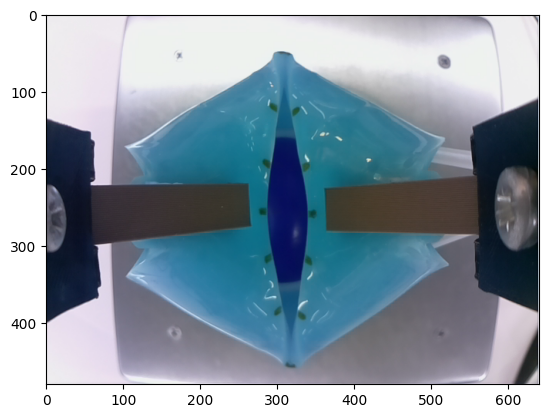

b'061.5,055.7,0329.2,0331.2\r\n'
Data number 17
['061.5', '055.7', '0329.2', '0331.2']
b'059.6,053.1,0432.8,0235.1\r\n'
['059.6', '053.1', '0432.8', '0235.1']
Enter something: 
b'000.0,000.0,0000.4,0000.4\r\n'
[INFO] [1677363996.239529]: Image received...


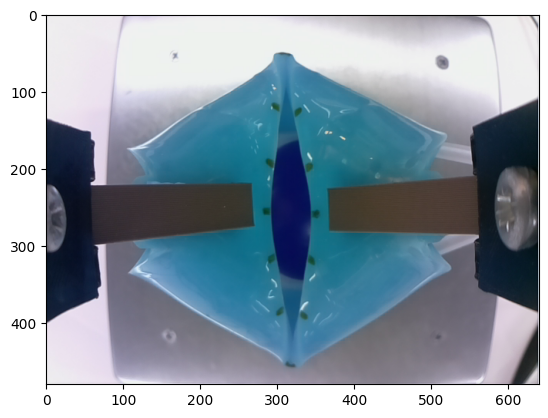

b'060.6,061.0,0292.5,0294.3\r\n'
Data number 18
['060.6', '061.0', '0292.5', '0294.3']
b'059.2,060.5,0401.9,0205.0\r\n'
['059.2', '060.5', '0401.9', '0205.0']


In [5]:
class Nodo(object):
    def __init__(self, dxl_motor):
        
        self.state = 0
        
        self.input_thread = threading.Thread(target=self.get_input)
        self.input_thread.daemon = True
        self.input_thread.start()
        
        self.image_array = []
        self.pressure_reading_1 = []
        self.pressure_reading_2 = []
        self.force_reading_1 = []
        self.force_reading_2 = []
        self.weight_reading_1 = []
        self.weight_reading_2 = []
        
        self.command = '0'
        self.take_photo = '0'
        self.dxl_motor = dxl_motor
        self.initialise_motor()
        
        self.ser = serial.Serial('/dev/ttyACM0', 57600, timeout=1)
        self.initialise_arduino()
        
        self.br = CvBridge()

        self.loop_rate = rospy.Rate(4)

        # Publishers
        self.pub = rospy.Publisher('number_command', Float64, queue_size=10)

        # Subscribers
        rospy.Subscriber("/image_capture",Image,self.callback)
    
    def initialise_arduino(self):
        time.sleep(2) # wait for the arduino to initialise
        self.ser.read(200) # clear the serial buffer
    
    def untare_read_arduino(self):
        # 0: clear tare and read, 1: tare and read, 2: read
        self.ser.write(b'0')
        time.sleep(0.1)
        return self.ser.read(40)
    
    def tare_read_arduino(self):
        # 0: clear tare and read, 1: tare and read, 2: read
        self.ser.write(b'1')
        time.sleep(0.1)
        return self.ser.read(40)
    
    def read_arduino(self):
        # 0: clear tare and read, 1: tare and read, 2: read
        self.ser.write(b'2')
        time.sleep(0.1)
        return self.ser.read(40)
    
    def initialise_motor(self):
        self.dxl_motor.set_current_position_mode()
        self.dxl_motor.read_operation_mode()
        self.dxl_motor.set_goal_current(50)
        
    def move_jaw(self, position):
        self.dxl_motor.torque_enable()
#         print(f"current position is {self.dxl_motor.read_present_position()}")
        self.dxl_motor.set_goal_position(position)
    
    def disable_jaw(self):
        self.dxl_motor.torque_disable()
    
    def get_input(self):
        while True:
            self.command = input("Enter something: ")
            time.sleep(1)
    
    def callback(self, msg):
        rospy.loginfo('Image received...')
        self.image = self.br.imgmsg_to_cv2(msg)
        self.image_array.append(self.image)
        plt.imshow(self.image)
        plt.show()
    
    def store_arduino_data(self, data):
        text = re.findall('\d+\.\d+', data.decode("utf-8"))
        print(text)
        self.pressure_reading_1.append(float(text[0]))
        self.pressure_reading_2.append(float(text[1]))
        self.force_reading_1.append(float(text[2]))
        self.force_reading_2.append(float(text[3]))
    
    def store_arduino_data_weight(self, data):
        text = re.findall('\d+\.\d+', data.decode("utf-8"))
        print(text)
        self.weight_reading_1.append(float(text[2]))
        self.weight_reading_2.append(float(text[3]))
    
    def save_data(self):
        image_name = []
        directory = './Grasp_dataset_4/Grasp_dataset_test/'
        
        start_number = 0
        
        for i in range(0, len(self.image_array)):
            image_name.append('Teimage' + str(i+start_number).zfill(3) + '.jpg')
            cv2.imwrite(directory +'Teimage' + str(i+start_number).zfill(3) + '.jpg', my_node.image_array[i])
        
        header = ['image_name', 'weight_reading_1', 'weight_reading_2', 'pressure_reading_1', 'pressure_reading_2', 'force_reading_1', 'force_reading_2', 'label']
        grasp_df = pd.concat([pd.Series(image_name), pd.Series(self.weight_reading_1), pd.Series(self.weight_reading_2), pd.Series(self.pressure_reading_1), pd.Series(self.pressure_reading_2), pd.Series(self.force_reading_1), pd.Series(self.force_reading_2), pd.Series(np.repeat('test', len(self.image_array)))], axis=1, keys=header)
        
        combined_df_set = pd.read_csv(directory + 'Grasp_dataset_test.csv')
        
        combined_df_set = pd.concat([combined_df_set, grasp_df], axis=0)
        
        combined_df_set.to_csv(directory + 'Grasp_dataset_test.csv', index=False)
        
    def start(self):
        rospy.loginfo("Timing images")

        while not rospy.is_shutdown():
            
            if self.command == '':
                self.command = '0'
                print(self.tare_read_arduino())
                time.sleep(0.5)
                self.move_jaw(1900)
                time.sleep(1.6)
                self.pub.publish(5201314)
                data = self.read_arduino()
                print(data)
                print('Data number ' + str(len(self.image_array)))
                self.store_arduino_data(data)
                time.sleep(0.5)

                time.sleep(1.9)
                self.pub.publish(1314)
                data = self.read_arduino()
                print(data)
                self.store_arduino_data_weight(data)
                time.sleep(2.8)
                self.move_jaw(200)

            elif self.command == '3':
                self.disable_jaw()
        
            self.loop_rate.sleep()

if __name__ == '__main__':
    rospy.init_node("command_publisher", anonymous=True)
    dxl_motor = Dynamixel_motor(1, 57600, '/dev/ttyUSB0')
    my_node = Nodo(dxl_motor)
    my_node.start()

In [7]:
my_node.save_data()